# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your http://notebook.acuna.io workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

## Question 1 (15 pts):
Computing derivative for a general computational graph

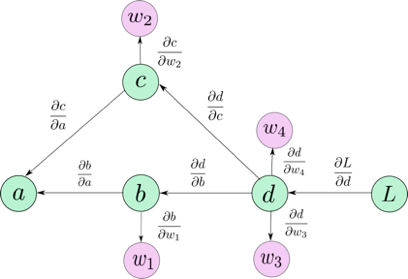

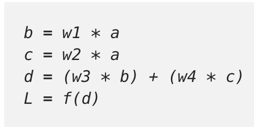

Use the following definition of computational graph:

In [2]:
# READ ONLY CELL
a = Variable(torch.FloatTensor([1]), requires_grad=True)
w1, w2, w3, w4 = [Variable(torch.FloatTensor([1]), requires_grad=True),
                  Variable(torch.FloatTensor([2]), requires_grad=True),
                  Variable(torch.FloatTensor([-1]), requires_grad=True),
                  Variable(torch.FloatTensor([4]), requires_grad=True)
                 ]
b = w1*a
c = w2*a
d = w3*b + w4*c
L = 10 - d

With Pytorch, Compute the following and store it in a `dL_w2`
$$
\frac{dL}{dw_2}
$$

**Note: You will need to reexecute the code definition above after calling the `backward()` every time you extract the derivative of another variable**

In [3]:
# YOUR CODE HERE
L.backward()
dL_w2=w2.grad

In [4]:
# 20 pts
assert type(dL_w2) == torch.Tensor
np.testing.assert_array_less(dL_w2.numpy(), 0)
### START HIDDEN TEST
np.testing.assert_equal(dL_w2.numpy()[0], -4)
### END HIDDEN TEST

## Question 2 (20 pts)

In this homework, we will analyze different architectures for the prediction of MNIST digits.
The code below will load the MNIST data and create a data loader for training and testing (`trainloader` and `testloader`, respectively). Also, the code defines a special layer that flattens a volumetric layer into a set of neurons (`Flatten`) leaving the road ready for creating a fully connected layer.

In [5]:
# READ ONLY CELL
# MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='~', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='~', train=False, transform=transform)

# create training and testing data
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False, num_workers=0)

# special module to flatten a layer
# Flattens the dimensions of a convolutional network. This module does not exist in pytorch so we have
# to create it
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

The following function creates a neural network but requires you to specificy the correct input and output dimensions to the last layer, which is a fully connected layer.

In [6]:
# READ ONLY CELL
def create_cnn(fully_connected_input, fully_connected_output):
    """
    Convolutional neural network with
    CONV => ReLU => MaxPool => FC
    """
    model = nn.Sequential(
        nn.Conv2d(1, 3, kernel_size=4, stride=2, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),    
        Flatten(),
        nn.Linear(fully_connected_input, fully_connected_output)
    )
    return model

The function `create_cnn` creates a very specific architecture (CONV => ReLU => MaxPool => FC) but requires you to enter the correct number of input neurons for the fully connected layer (`fully_connected_input`) and output neurons for the network (`fully_connected_output`). 

Consider that the MNIST images have width and height 28. The convolutional layer has a 3 kernels of size 4, stride of 2, and padding of 2. The max pooling layer has a kernel size of 3 and stride of 2. Below, define the appropriate variables `fully_connected_input` and `fully_connected_output` so that `create_cnn` can be appropriately used to create a CNN for the MNIST dataset. Consider that for MNIST you are predicting digits.

Use the equations seen in class to compute the volume of the convolution layer and max pooling layer. You will use this volumes and slice dimensions for determining these variables.

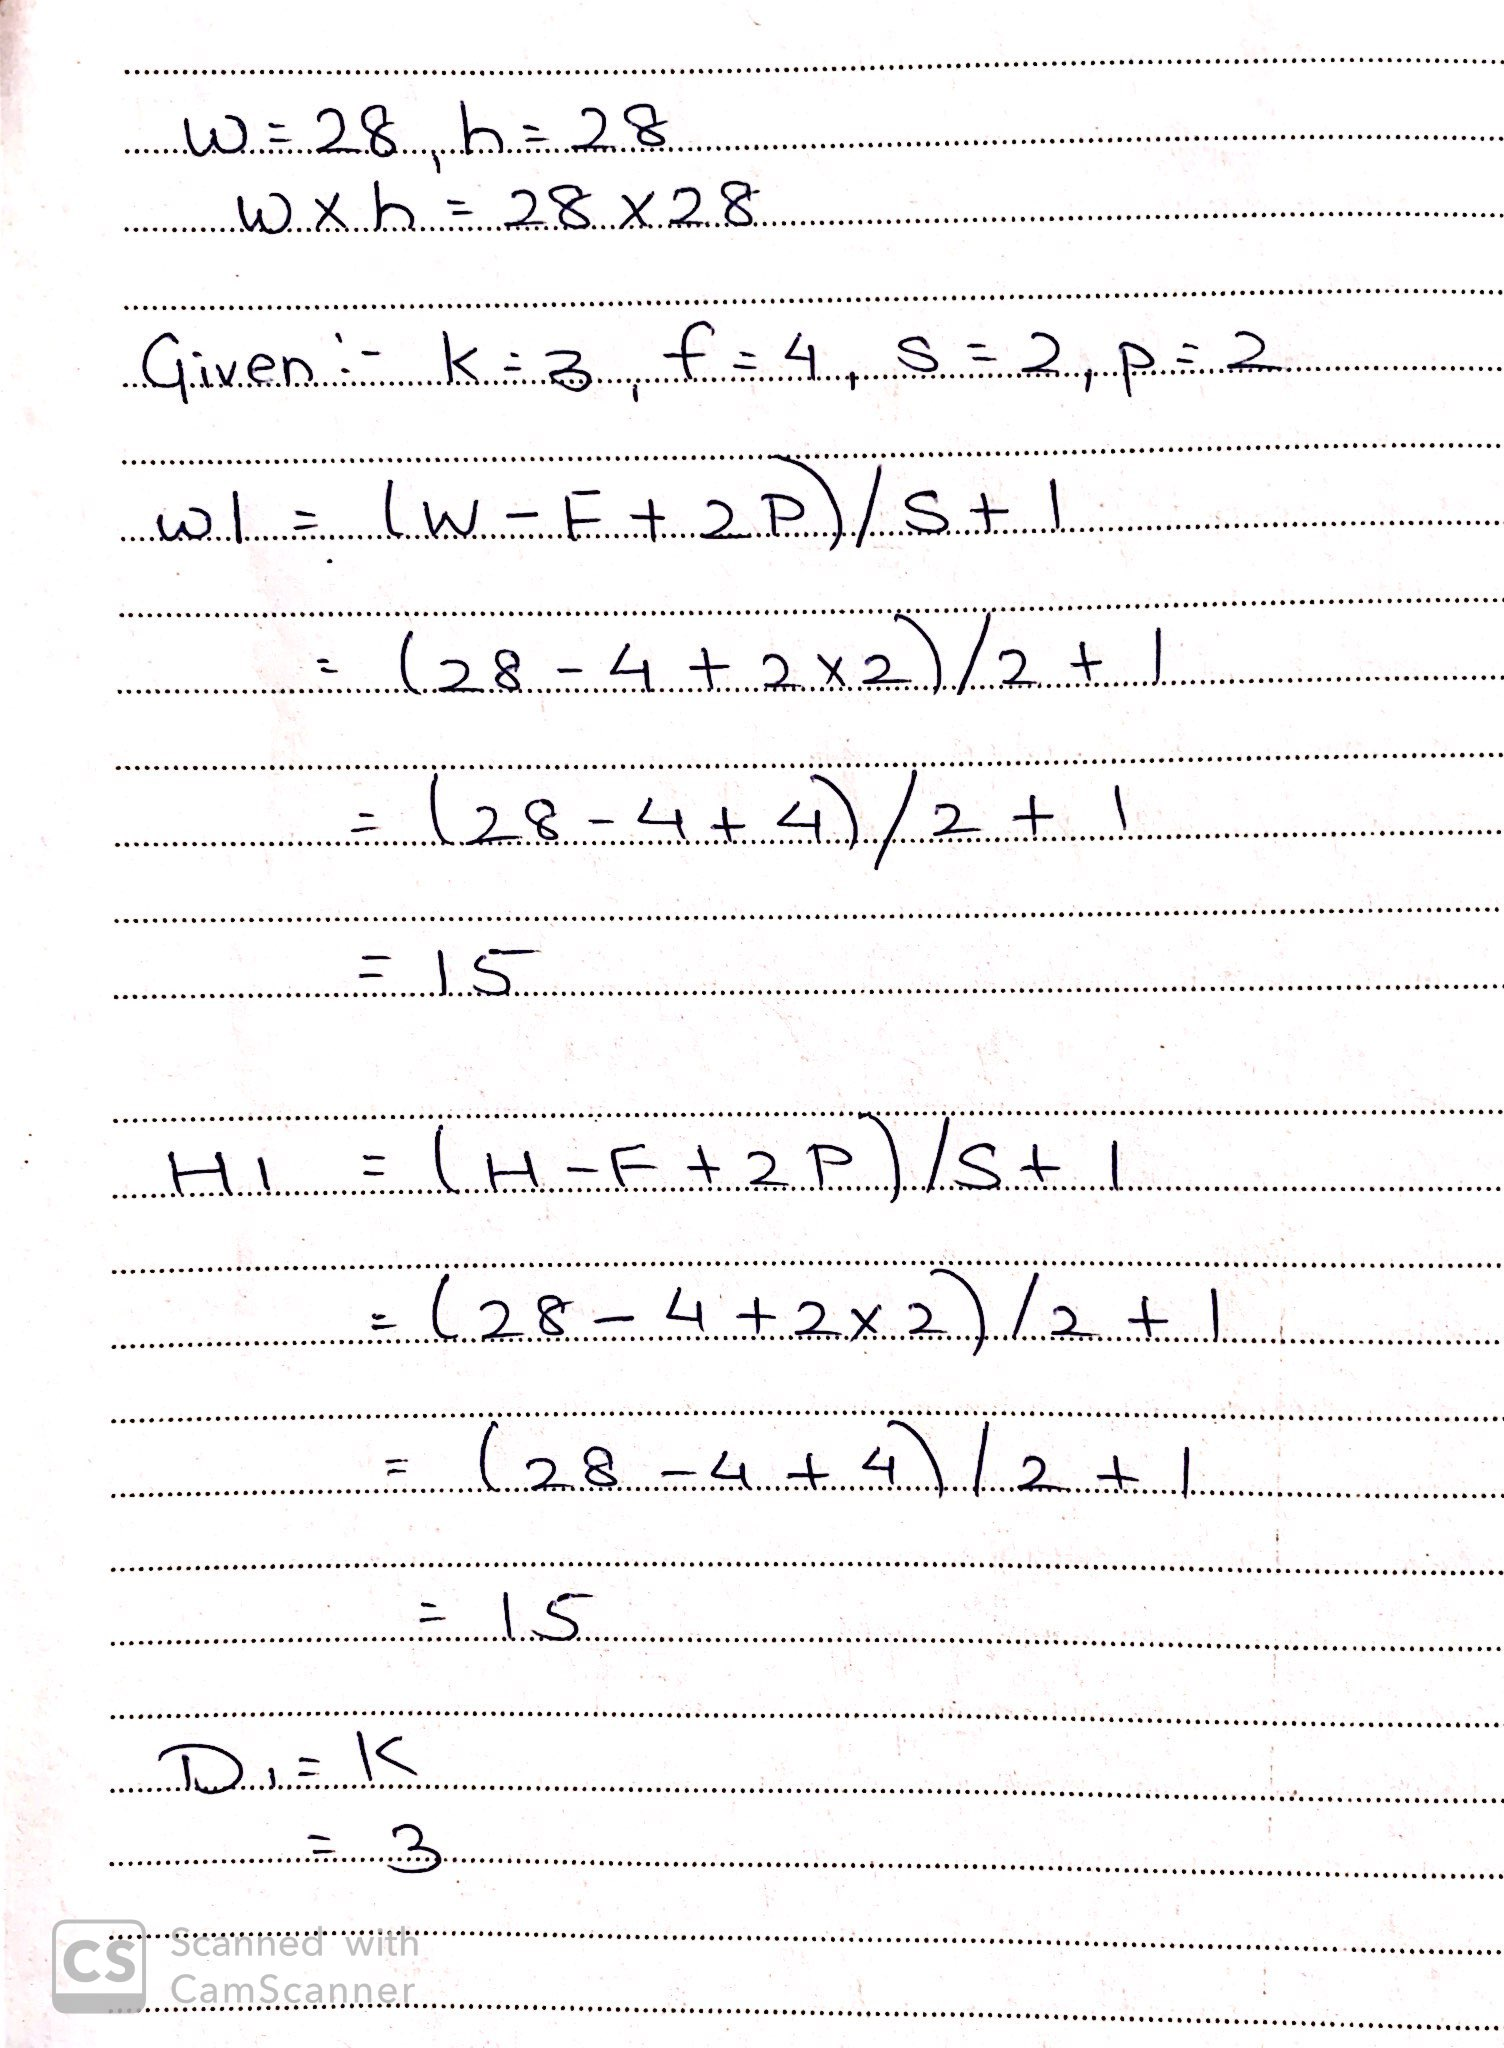

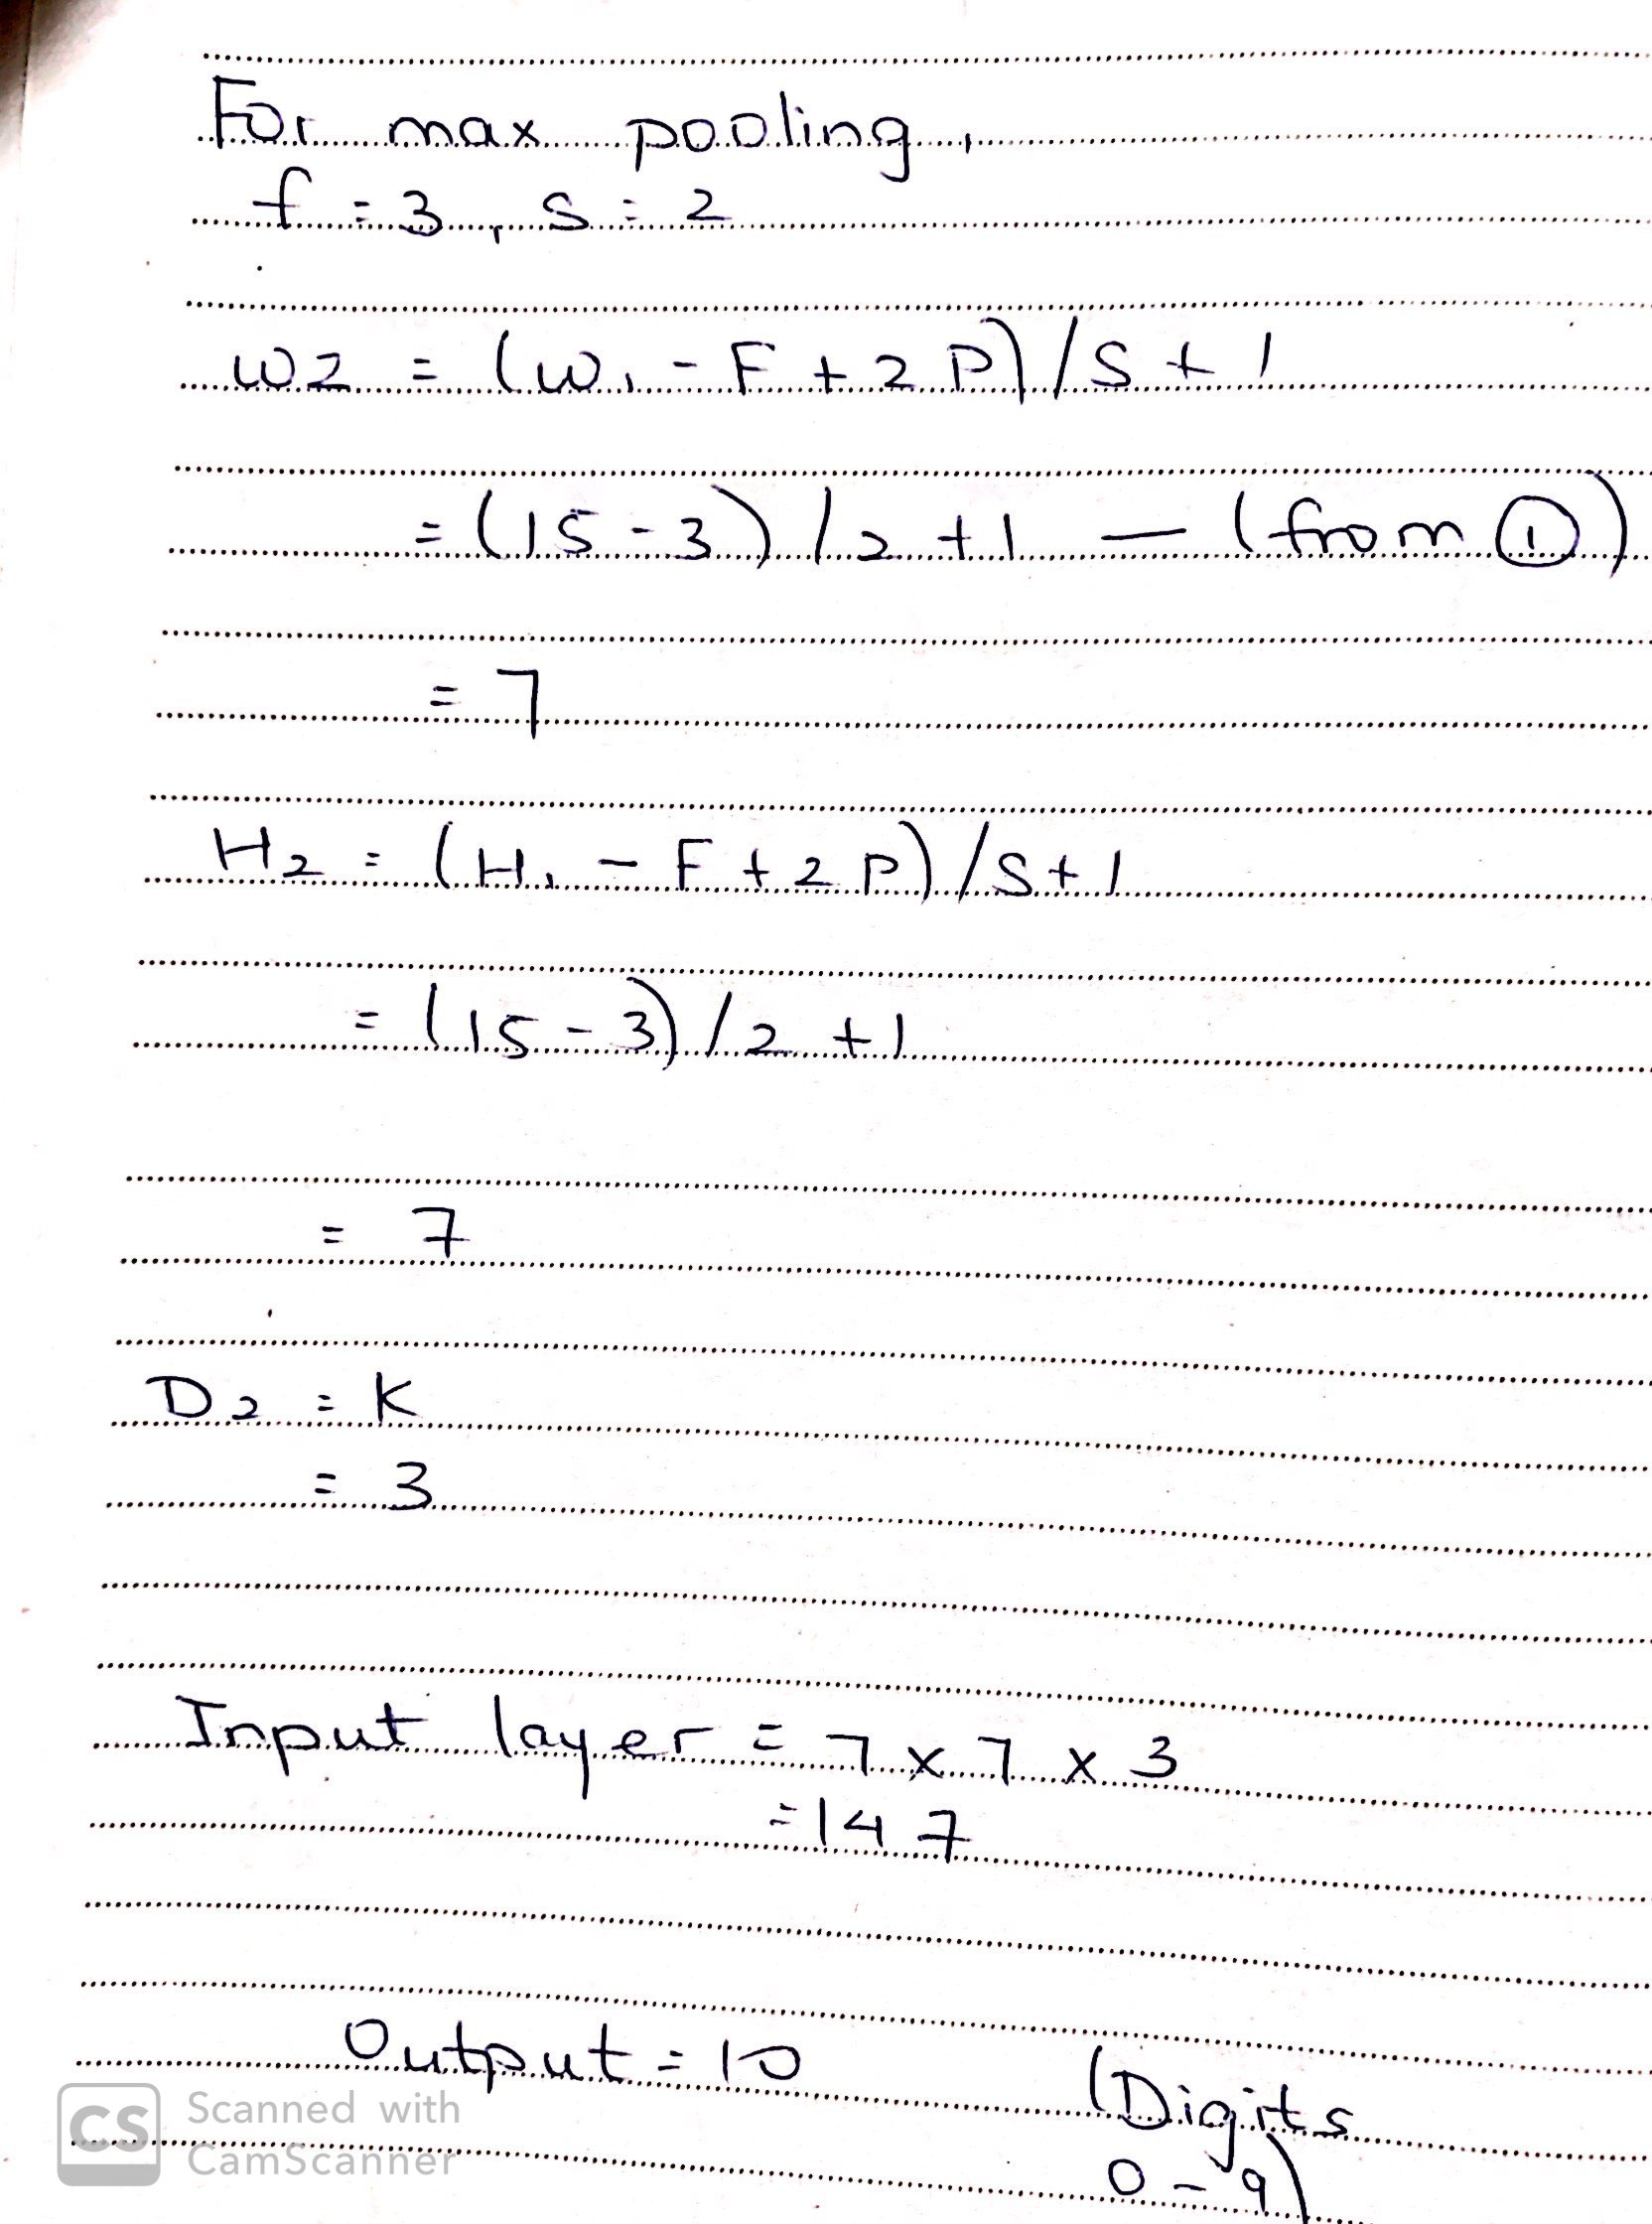

In [7]:
# YOUR CODE HERE
fully_connected_input=147
fully_connected_output=10

Prediction from uninitialized CNN: tensor([[ 0.1348, -0.1383, -0.2168,  0.0302, -0.0711, -0.4122,  0.0016, -0.0296,
          0.1428,  0.0075]], grad_fn=<AddmmBackward>)


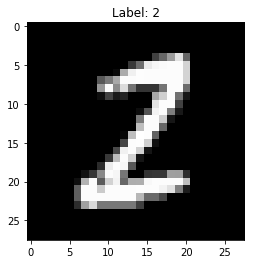

In [8]:
# 40 pts
X, label = next(iter(trainloader))
plt.imshow(X[0, 0].numpy(), 'gray');
plt.title(f'Label: {str(label[0].numpy())}');
assert create_cnn(fully_connected_input, fully_connected_output)
model = create_cnn(fully_connected_input, fully_connected_output)
print(f"Prediction from uninitialized CNN: {model(X[[0]])}")

## Question 3 (20 pts)

Consider the following periodic dataset:

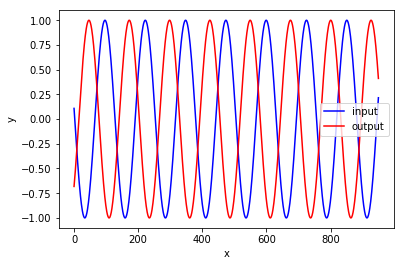

In [9]:
# READ ONLY CELL
import numpy as np
import torch

np.random.seed(2)

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float32')

X0 = data[:, :-50]
Y0 = data[:, 50:]

# randomize the data
dataloader = DataLoader(TensorDataset(
    torch.from_numpy(X0).reshape(X0.shape[0], X0.shape[1], -1), 
    torch.from_numpy(Y0).reshape(Y0.shape[0], Y0.shape[1], -1)), batch_size=10, 
                        shuffle=True)

# Flattens the dimensions of a convolutional network
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(CustomLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)

    def forward(self, x):
        output, _ = self.lstm(x)
        return output

plt.plot(X0[0], 'b');
plt.plot(Y0[0], 'r');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(['input', 'output']);

In [10]:
# READ ONLY CELL
def train_and_display(model, dataloader):
    num_epochs = 100
    learning_rate = 0.01
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Train the model
    total_step = len(dataloader)
    loss_list = []
    acc_list = []
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(dataloader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
            plt.figure(figsize=[2,2])
            plt.plot(labels[0, :, 0].detach().numpy(), 'b');
            plt.plot(model(inputs)[0, :, 0].detach().numpy(), 'r--');
            plt.xlabel('x');
            plt.ylabel('y');
            plt.title(f'Epoch #{epoch+1}');
            plt.legend(['data', 'prediction']);            

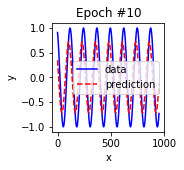

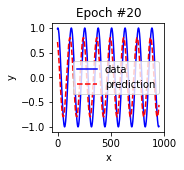

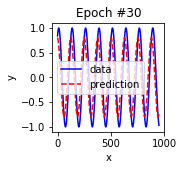

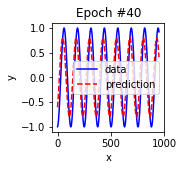

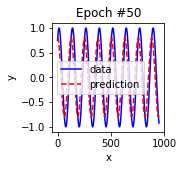

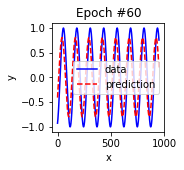

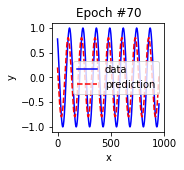

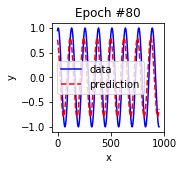

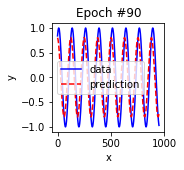

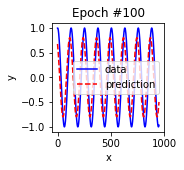

In [11]:
linear_regression = nn.Sequential(nn.Linear(1, 1))
train_and_display(linear_regression, dataloader)

Define a multilayer perceptron model with 3 hidden layers and the following number of units per hidden layer: 5, 10, and 5. Use the sigmoid activation function (`nn.Sigmoid`). Below is the neural network partially defined. Copy it into the answer cell and complete `____`:

```python
MLP = nn.Sequential(
    nn.Linear(1, ____),
    nn.Sigmoid(),
    nn.Linear(____, 10),
    ____,
    nn.Linear(____, ____),
    nn.Sigmoid(),
    nn.Linear(5, ____))
```



In [12]:
# YOUR CODE HERE
MLP = nn.Sequential(
    nn.Linear(1, 5),
    nn.Sigmoid(),
    nn.Linear(5, 10),
    nn.Sigmoid(),
    nn.Linear(10, 5),
    nn.Sigmoid(),
    nn.Linear(5, 1))

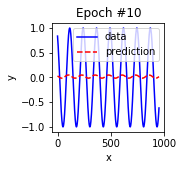

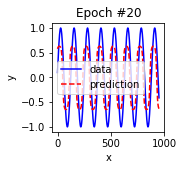

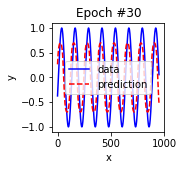

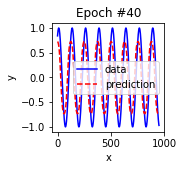

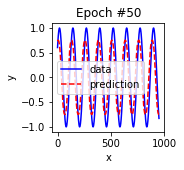

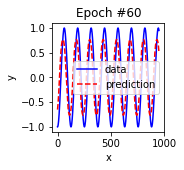

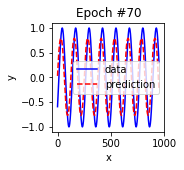

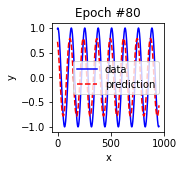

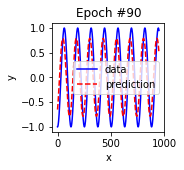

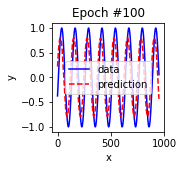

In [13]:
# plot the performance of the model
train_and_display(MLP, dataloader)

In [14]:
# 10 pts
assert type(MLP) == nn.Sequential
np.testing.assert_equal(
    set([type(L) for L in list(MLP.children())]),
    {nn.Sigmoid, nn.Linear}
)
assert len(list(MLP.children())) == 7

## Question 4 (20 pts)
Follow the code in the `pytorch_cnn_rnn.ipynb` notebook and use the `CustomLSTM` module defined above to create a neural network that stacks two LSTM, one with 10 hidden units and another with 5 hidden units. Assign the model to the variable `stacked_lstm`.

```python
stacked_lstm = nn.Sequential(
                      _____, 
                      _____,
                      nn.Linear(____, 1))
```

In [15]:
# YOUR CODE HERE
stacked_lstm = nn.Sequential(
    CustomLSTM(1, 10),
    CustomLSTM(10,5),
    nn.Linear(5, 1),
)

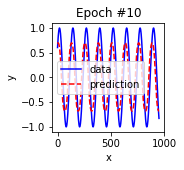

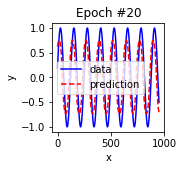

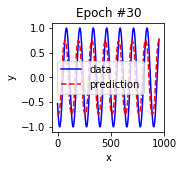

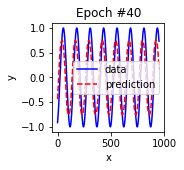

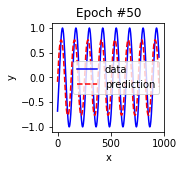

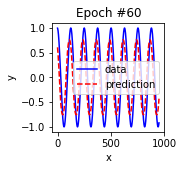

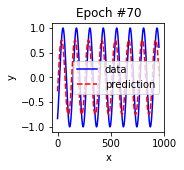

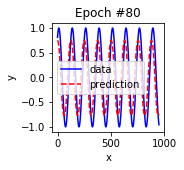

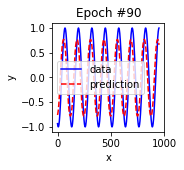

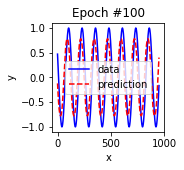

In [16]:
# plot the performance of the model - this should take significantly more time
train_and_display(stacked_lstm, dataloader)

In [17]:
# 10 pts
assert type(stacked_lstm) == nn.Sequential
np.testing.assert_equal(
    set([type(L) for L in list(stacked_lstm.children())]),
    {CustomLSTM, nn.Linear}
)